### Blog post ideas
- recreate the small steps I took in a tutorial style series?
- figuring out and smoothing telemetry

In [1]:
#install pint if needed
try:
    from pint import UnitRegistry
except ImportError:
    %pip install pint
    
# import units
from pint import UnitRegistry
units = UnitRegistry()

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

In [3]:
# import functions from modsim

from modsim import *

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

For this example we will be using a AJ-60A booster from the Atlas V.

Assumptions:
- drag coefficient is the same as a baseball
- earth is a perfect circle 12,756 km in diameter (~equatorial diameter)
- thrust is constant

TODO:
- improve gnc to get to orbit
    - multiple burns??
    - figure out what the burn should be to get to orbit
    - fudge burn time to get there
- multiple stages
    - unify trust/burn time/mass into a class
    - control with gnc
- improve trust equations, [see specific impulse by nasa](https://www.grc.nasa.gov/www/k-12/airplane/specimp.html)
- throttle trust


Pitch over happens at 244m, for this simulation we'll say the angle change instantaneously from 90 degrees (vertical) to 45 degrees. In the future a more complicated approach will be used. [This article](https://globaljournals.org/GJSFR_Volume12/6-Computational-Algorithm-for-Gravity.pdf) explains more of the math behind pitch over.

In [4]:
# from gravity import calc_gravity
# print(calc_gravity(Vector(0,0), params))
# print(calc_gravity(Vector(100000, 0), params))

The drag force is dependant on the density of the air. Which depends on the altitude, temperature, and pressure. To simplify this we will be use values from [this table](https://www.engineeringtoolbox.com/standard-atmosphere-d_604.html). In the future we might enhance this, perhaps evening pulling real temp and pressure data from somewhere online. [This](https://www.grc.nasa.gov/www/k-12/airplane/atmosmet.html) NASA article explains the math some more.

In [5]:
# from drag import drag_force
# print(drag_force(Vector(10, 10), 0, system))

In [6]:
from simulation import run_sim

results, telemetry_df = run_sim()

GEM 63 - 1  burn start:  0
GEM 63 - 2  burn start:  0
GEM 63 - 3  burn start:  0
GEM 63 - 4  burn start:  0
GEM 63 - 5  burn start:  0
Atlas CCB  burn start:  0
GEM 63 - 1  burn stop:  28.465703966707178
GEM 63 - 2  burn stop:  28.465703966707178
GEM 63 - 3  burn stop:  28.465703966707178
GEM 63 - 4  burn stop:  28.465703966707178
GEM 63 - 5  burn stop:  28.465703966707178
Atlas CCB  burn stop:  28.465703966707178
The solver successfully reached the end of the integration interval.


In [7]:
flight_time = results.index[-1]
flight_time

300000.0

21886570202.017178
21191606017.910633
0.0
6378010.0


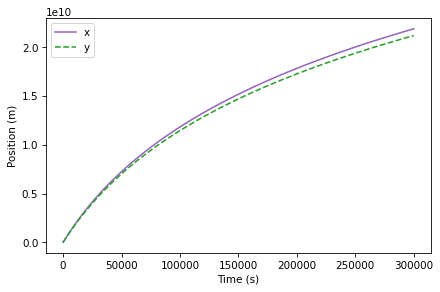

In [8]:
results.x.plot(color='C4')
results.y.plot(color='C2', style='--')

print(results.x.max())
print(results.y.max())
print(results.x.min())
print(results.y.min())

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

#### Graph jitteriness

We can smooth out the plots below by using the trick modsim.py uses on line 312. Alternatively we could either extend the modsim function to take this extra data we want to track, or directly call solve_ivp without modsim.

TODO:
- split telemetry data
    - by stage? or at least before/after last stage cutoff
    - since when it is ballistic, the values are all significantly smaller
- figure out why x-y plot is weird
    - Too much thrust causing it to easily overcome gravity?
- figure out / trim leading outlier data
    - 'everything' seams to start at zero? even mass
- smooth data

21929354583.190773
21233019101.993164
-608147.9178682861
6378010.0


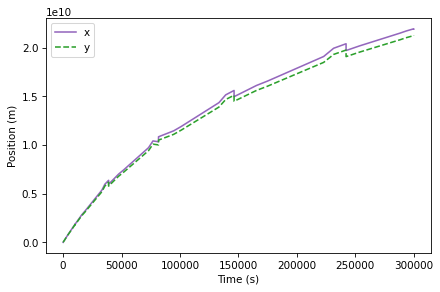

In [9]:
telemetry_df.x.plot(color='C4')
telemetry_df.y.plot(color='C2', style='--')

print(telemetry_df.x.max())
print(telemetry_df.y.max())
print(telemetry_df.x.min())
print(telemetry_df.y.min())

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

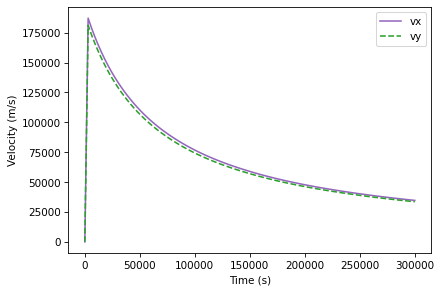

In [10]:
results.vx.plot(color='C4')
results.vy.plot(color='C2', style='--')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

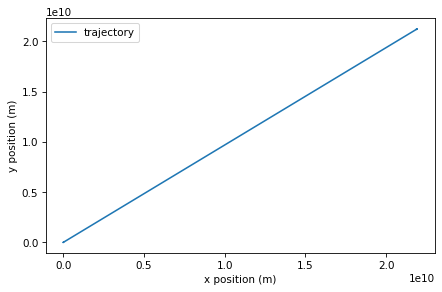

In [11]:
from simulation import params

def plot_trajectory(results):
    # x = results.x
    # y = results.y
    x = telemetry_df['x'].values
    y = telemetry_df['y'].values
    make_series(x, y).plot(label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')
    
    ax = plt.gca()
    pp2 = plt.Circle((0, 0), params.earth_diameter / 2)
    pp2.set_facecolor('#37a344')
    ax.add_patch(pp2)
    
    

plot_trajectory(results)

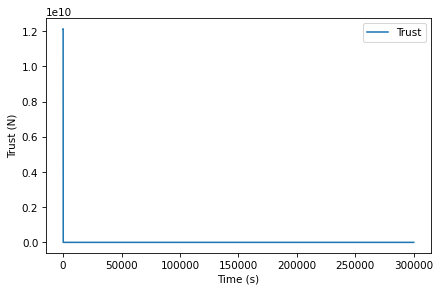

In [20]:
telemetry_df.trust_f.plot(label='Trust')

decorate(xlabel='Time (s)',
            ylabel='Trust (N)')

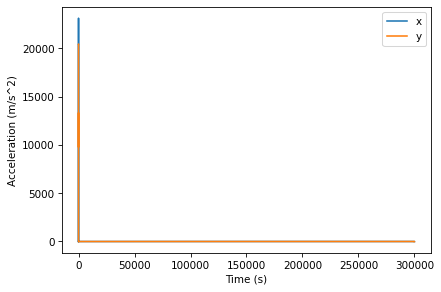

In [13]:
telemetry_df.ax.plot(label='x')
telemetry_df.ay.plot(label='y')

decorate(xlabel='Time (s)',
            ylabel='Acceleration (m/s^2)')

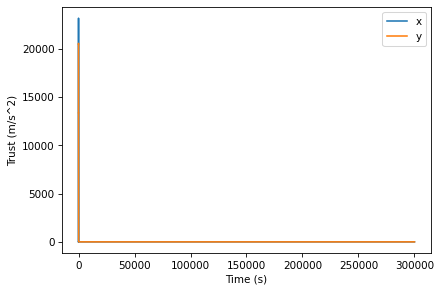

In [14]:
telemetry_df.atx.plot(label='x')
telemetry_df.aty.plot(label='y')

decorate(xlabel='Time (s)',
            ylabel='Trust (m/s^2)')

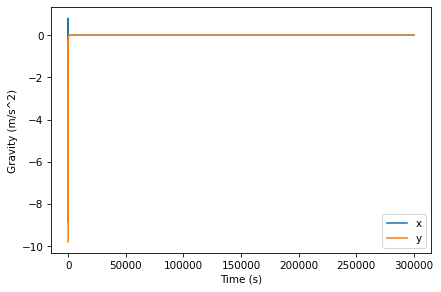

In [15]:
telemetry_df.gx.plot(label='x')
telemetry_df.gy.plot(label='y')

decorate(xlabel='Time (s)',
            ylabel='Gravity (m/s^2)')

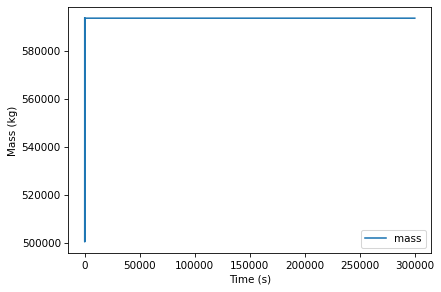

In [16]:
telemetry_df.mass.plot(label='mass')

decorate(xlabel='Time (s)',
            ylabel='Mass (kg)')

In [17]:
from matplotlib.pyplot import plot

xlim = results.x.min(), results.x.max()
ylim = results.y.min(), results.y.max()

def draw_func(t, state):
    plot(state.x, state.y, 'bo')
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=xlim,
             ylim=ylim)

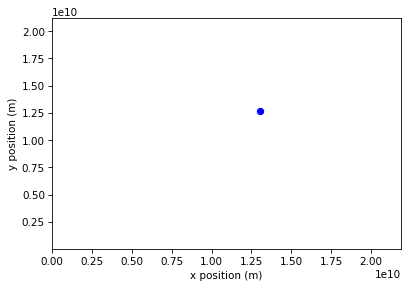

In [21]:
animate(results, draw_func)